# Set up the environment

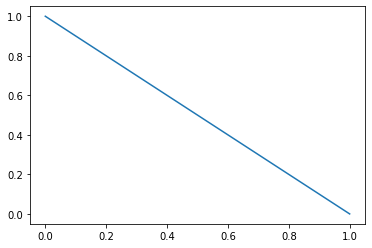

INFO:root:test
INFO:root:test


(-75, -56)
Import of badexp.ADEXPBackend failed due to:
No module named 'neuronunit.models.backends.badexp'
Import of bhh.BHHBackend failed due to:
No module named 'neuronunit.models.backends.bhh'
Import of general_pyNN.PYNNBackend failed due to:
No module named 'pyNN'


In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.plot([0,1],[1,0])
plt.show()
import hide_imports
from neuronunit.optimisation.optimization_management import inject_and_plot_model


# Design simulated data tests

In [2]:
def jrt(use_test,backend):
    use_test = hide_imports.TSD(use_test)
    use_test.use_rheobase_score = True
    edges = hide_imports.model_parameters.MODEL_PARAMS[backend]

    OM = hide_imports.OptMan(use_test,\
                backend=backend,\
                boundary_dict=edges,\
                protocol={'allen': False, 'elephant': True})

    return OM



In [3]:
test_frame = hide_imports.get_neab.process_all_cells()
test_frame.pop('Olfactory bulb (main) mitral cell',None)
stds = {}
for k,v in hide_imports.TSD(test_frame['Neocortex pyramidal cell layer 5-6']).items():
    temp = hide_imports.TSD(test_frame['Neocortex pyramidal cell layer 5-6'])[k]
    stds[k] = temp.observation['std']
    print((temp.name,temp.observation))
OMObjects = []
backends = ["RAW"]
import copy
cloned_tests = copy.copy(test_frame['Neocortex pyramidal cell layer 5-6'])
import copy
for b in backends:        
    OM = jrt(cloned_tests,b)
    OMObjects.append(OM)
rt_outs = []

('RheobaseTest', {'mean': array(213.84958333) * pA, 'std': array(170.45245472) * pA, 'n': 32})
('InputResistanceTest', {'mean': array(120.67207364) * Mohm, 'std': array(77.63316083) * Mohm, 'n': 86})
('TimeConstantTest', {'mean': array(15.73424242) * ms, 'std': array(7.31162637) * ms, 'n': 33})
('CapacitanceTest', {'mean': array(150.58416667) * pF, 'std': array(139.68388463) * pF, 'n': 12})
('RestingPotentialTest', {'mean': array(-68.24814346) * mV, 'std': array(6.53234788) * mV, 'n': 79})
('InjectedCurrentAPWidthTest', {'mean': array(1.20769388) * ms, 'std': array(0.53434592) * ms, 'n': 49})
('InjectedCurrentAPAmplitudeTest', {'mean': array(80.43510204) * mV, 'std': array(12.74880304) * mV, 'n': 49})
('InjectedCurrentAPThresholdTest', {'mean': array(-42.73572327) * mV, 'std': array(8.04073233) * mV, 'n': 53})


In [4]:
for OM in OMObjects:
   print(OM.backend)
   x= {k:v for k,v in OM.tests.items() if 'mean' in v.observation.keys() or 'value' in v.observation.keys()}
   cloned_tests = copy.copy(OM.tests)
   OM.tests = hide_imports.TSD(cloned_tests)
   rt_out = OM.simulate_data(OM.tests,OM.backend,OM.boundary_dict)
   #print(rt_out)


RAW
RheobaseTest
{'value': array(97.67932892) * pA} is this called?
InputResistanceTest
{'value': array(27421576.00563999) * kg*m**2/(s**3*A**2)} is this called?
TimeConstantTest
{'value': array(57.22626992) * ms} is this called?
CapacitanceTest
{'value': array(2.08690667e-09) * s**4*A**2/(kg*m**2)} is this called?
RestingPotentialTest
{'mean': array(-60.28855435) * mV, 'std': array(7.10542736e-15) * mV} is this called?
InjectedCurrentAPWidthTest
{'mean': array(0.00024) * s, 'std': array(0.) * s, 'n': 1} is this called?
InjectedCurrentAPAmplitudeTest
{'value': array(59.31165436) * mV, 'mean': array(59.31165436) * mV, 'std': array(0.) * mV, 'n': 1} is this called?
InjectedCurrentAPThresholdTest
{'mean': array(-20.11805319) * mV, 'std': array(0.) * mV, 'n': 1} is this called?
Random simulated data tests made


In [5]:
penultimate_tests = hide_imports.TSD(test_frame['Neocortex pyramidal cell layer 5-6'])
for k,v in penultimate_tests.items():
    temp = penultimate_tests[k]

    v = rt_out[1][k].observation
    v['std'] = stds[k]
simulated_data_tests = hide_imports.TSD(penultimate_tests)

# Show what the randomly generated target waveform the optimizer needs to find actually looks like

(AnalogSignal with 1 channels of length 130000; units mV; datatype float64 
 sampling rate: 100.0
 time: 0.0 to 1.3,
 <module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>)

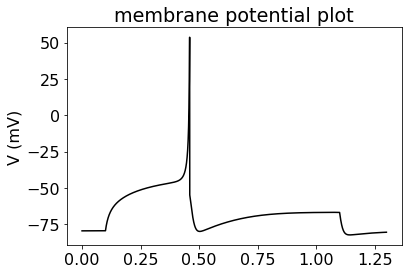

In [6]:
target = rt_out[0]
target.rheobase
inject_and_plot_model(target)

# Commence optimization of models on simulated data sets

# first lets just optimize over single objective functions at a time.

In [7]:
ga_out_rh = hide_imports.TSD([simulated_data_tests["RheobaseTest"]]).optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=10,NGEN=10)
opt_rh = ga_out_rh['pf'][0].dtc
opt_rh.obs_preds

,RheobaseTest,total
observations,97.67932891845703 pA,NaN
predictions,98.28477501869202 pA,NaN
scores,0.0028381,0.002838


In [8]:
ga_out_time = hide_imports.TSD([simulated_data_tests["TimeConstantTest"]]).optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=10,NGEN=10)
opt_time = ga_out_time['pf'][0].dtc
opt_time.obs_preds

,TimeConstantTest,total
observations,57.22626992206479 ms,NaN
predictions,57.40063841239529 ms,NaN
scores,0.0192096,0.01921


In [12]:
both = hide_imports.TSD([simulated_data_tests["TimeConstantTest"],simulated_data_tests["RheobaseTest"]]).optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=20,NGEN=5)
both = both['pf'][0].dtc
both.obs_preds

,TimeConstantTest,RheobaseTest,total
observations,57.22626992206479 ms,97.67932891845703 pA,NaN
predictions,57.97802988125641 ms,141.34504795074463 pA,NaN
scores,0.0854401,0.225878,0.311318


In [13]:
three = hide_imports.TSD([simulated_data_tests["InjectedCurrentAPWidthTest"],simulated_data_tests["TimeConstantTest"],simulated_data_tests["RheobaseTest"]]).optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=25,NGEN=6)


In [11]:
three = three['pf'][0].dtc
three.obs_preds

,InjectedCurrentAPWidthTest,TimeConstantTest,RheobaseTest,total
observations,0.00024000000000000003 s,57.22626992206479 ms,97.67932891845703 pA,NaN
predictions,0.00034 s,50.532601676896775 ms,178.6491572856903 pA,NaN
scores,0.1607,1.02182,0.454498,1.637021


# How about using all the objectives together?


In [ ]:
ga_out = simulated_data_tests.optimize(OMObjects[0].boundary_dict,backend=OMObjects[0].backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=20,NGEN=20)
opt = ga_out['pf'][0].dtc

In [ ]:
opt.rheobase


In [ ]:
inject_and_plot_model(opt)

In [ ]:
opt.obs_preds

In [ ]:
model = opt.dtc_to_model()
score = simulated_data_tests['TimeConstantTest'].judge(model)
pred = simulated_data_tests['TimeConstantTest'].prediction
print(pred)

In [ ]:
from neuronunit.optimisation.optimization_management import check_binary_match
check_binary_match(opt,origin)



##### 